# Lending Club: Risk Analysis and Gradient Boosting

Here is a short description of the data. For more info see: https://www.kaggle.com/wendykan/lending-club-loan-data

These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. A data dictionary is provided in a separate file.

## 1. Load libraries

In [2]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.2 MB/s eta 0:00:011


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
import seaborn
import warnings
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model, metrics
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras import optimizers, regularizers, initializers, Model
import keras.backend as K

import lightgbm
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import StackingClassifier as SC
from sklearn.ensemble import ExtraTreesClassifier as ETC

%matplotlib inline
warnings.filterwarnings('ignore')
print(tf.version.VERSION)
print('GPU is available' if tf.config.experimental.list_physical_devices('GPU') 
                          else 'GPU is NOT available')

2.2.0
GPU is NOT available


## 2. Load data

In [4]:
loan_df = pd.read_csv('../input/lending-club-loan-data/loan.csv', infer_datetime_format=True, parse_dates=['issue_d'])
loan_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
 #   Column                                      Non-Null Count    Dtype         
---  ------                                      --------------    -----         
 0   id                                          0 non-null        float64       
 1   member_id                                   0 non-null        float64       
 2   loan_amnt                                   2260668 non-null  int64         
 3   funded_amnt                                 2260668 non-null  int64         
 4   funded_amnt_inv                             2260668 non-null  float64       
 5   term                                        2260668 non-null  object        
 6   int_rate                                    2260668 non-null  float64       
 7   installment                                 2260668 non-null  float64       
 8   grade                                       2260668 non-null 

Remove obviously irrelevant columns!

In [5]:
loan_df.drop(['id', 'member_id', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)
print(loan_df.shape)

(2260668, 139)


## 3. Plot some columns

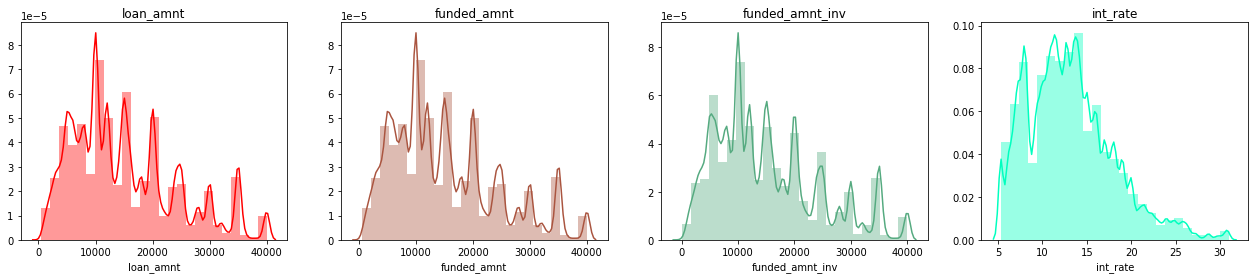

In [6]:
colnames = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate']

fig, axes = plt.subplots(1, 4, figsize=(22, 4))
for ii, cname in enumerate(colnames) :
    seaborn.distplot(loan_df[cname], bins=25, ax=axes[ii], color=[1-ii/3,ii/3,ii/4])
    axes[ii].set_title(cname)

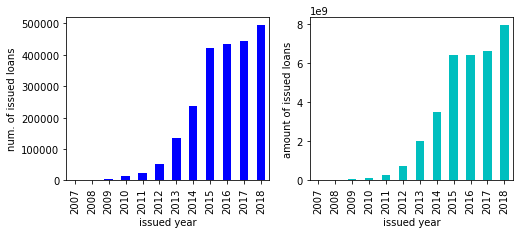

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
    
loan_df.loan_amnt.groupby(loan_df.issue_d.dt.year).count().plot(kind='bar', ax=axes[0], color='b')
axes[0].set_ylabel('num. of issued loans')
axes[0].set_xlabel('issued year')

loan_df.loan_amnt.groupby(loan_df.issue_d.dt.year).sum().plot(kind='bar', color='c', ax=axes[1])
axes[1].set_ylabel('amount of issued loans')
axes[1].set_xlabel('issued year');

## 4. Separating loans into "good" and "bad"

In [8]:
print(loan_df.loan_status.value_counts())

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64


In [9]:
bad_loans = ['Charged Off','Late (31-120 days)','In Grace Period','Late (16-30 days)',
             'Does not meet the credit policy. Status:Fully Paid','Default']

loan_df['good_loan'] = loan_df.loan_status.apply(lambda x: 0 if x in bad_loans else 1)
loan_df['bad_loan'] = loan_df.loan_status.apply(lambda x: 1 if x in bad_loans else 0)

## 5. Plot good and bad loans

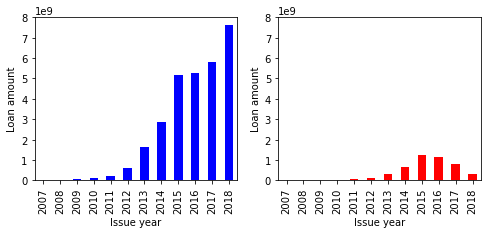

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))

loan_df.loan_amnt[loan_df.good_loan==1].groupby(loan_df.issue_d.dt.year).sum().plot(kind='bar', ax=axes[0], color='b')
axes[0].set_ylim([0, 8e9])
axes[0].set_ylabel('Loan amount')
axes[0].set_xlabel('Issue year')

loan_df.loan_amnt[loan_df.good_loan==0].groupby(loan_df.issue_d.dt.year).sum().plot(kind='bar', ax=axes[1], color='r')
axes[1].set_ylim([0, 8e9])
axes[1].set_ylabel('Loan amount')
axes[1].set_xlabel('Issue year');

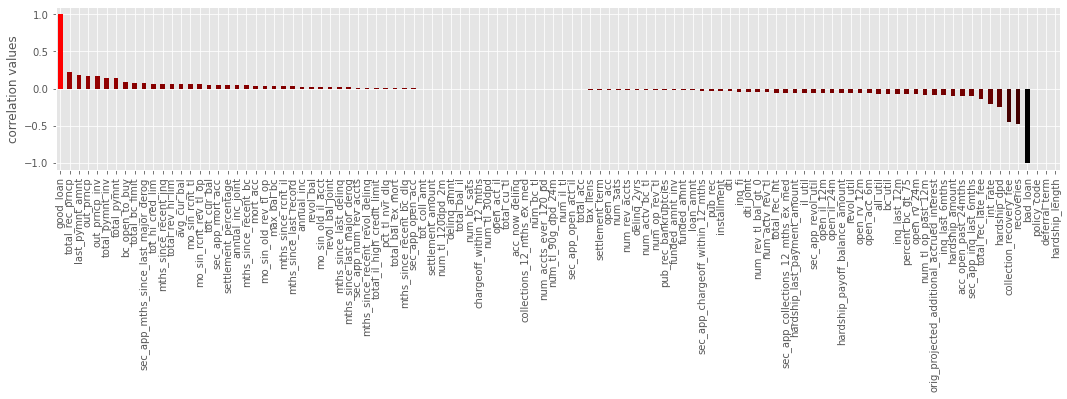

In [11]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 1, figsize=(18,3))

cc = loan_df.corrwith(loan_df.good_loan).sort_values(ascending=False)
mycols = [(0.5*(x+1),0,0) for x in cc]
cc.plot(kind='bar', color=mycols, ax=axes)
axes.set_ylabel('correlation values');

## 6. Loan condition for each state

In [12]:
ls = loan_df.loan_status.unique()
states = loan_df.addr_state.unique()
df = pd.DataFrame(columns=ls, index=states)
for col in ls :
    df[col] = loan_df.loan_amnt[loan_df.loan_status==col].groupby(loan_df.addr_state).count()

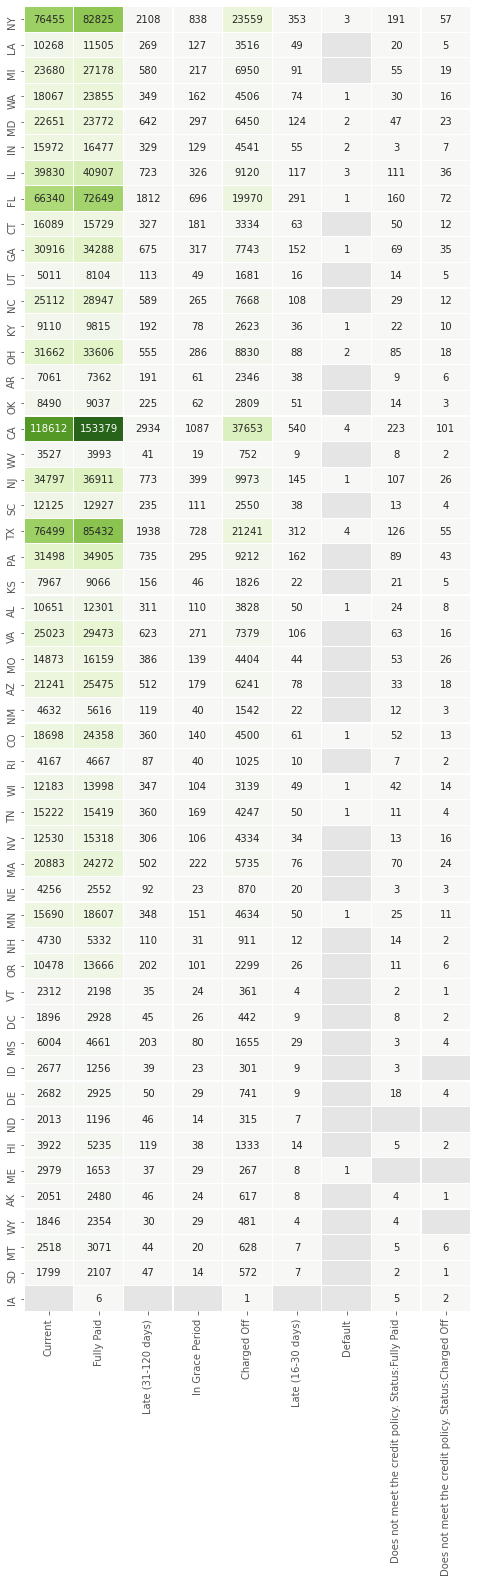

In [13]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(8, 24))

seaborn.set(font_scale=1.2)
seaborn.heatmap(df, vmin=0, cmap='PiYG', center=0, annot=True, fmt='.0f', annot_kws={"size":10}, 
                linewidths=0.2, linecolor='white', cbar=False);

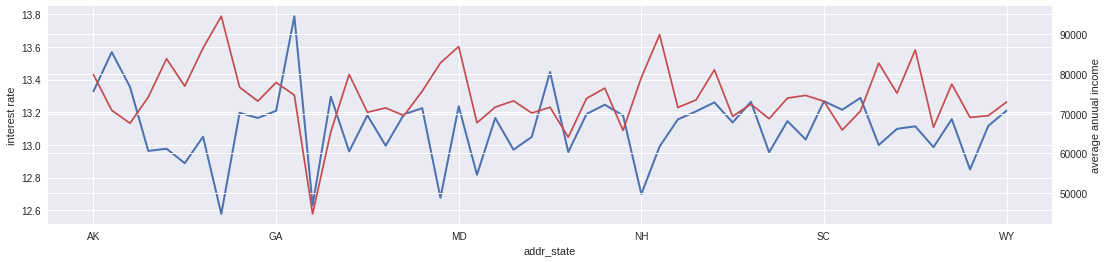

In [14]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(18,4))

loan_df.int_rate.groupby(loan_df.addr_state).mean().plot(color='b', lw=2, ax=ax)
ax.set_ylabel('interest rate')

ax2 = ax.twinx()
loan_df.annual_inc.groupby(loan_df.addr_state).mean().plot(color='r', ax=ax2)
ax2.set_ylabel('average anuual income');

California, Texas, New York and Florida are the states in which the highest amount of loans were issued. Annual income in these states is above the average annual income (maybe not Florida)

In [15]:
df = pd.DataFrame(columns=['st', 'avg_inc', 'int_rate', 'amnt_loans'], 
                 index=loan_df.addr_state.unique())
df.st = loan_df.addr_state.unique()
df.avg_inc = loan_df.annual_inc.groupby(loan_df.addr_state).mean()
df.int_rate = loan_df.int_rate.groupby(loan_df.addr_state).mean()
df.amnt_loans = loan_df.loan_amnt.groupby(loan_df.addr_state).sum()
df.head()

,st,avg_inc,int_rate,amnt_loans
NY,NY,81057.048011,13.260050,2767160700
LA,LA,75669.093956,13.225105,382046275
MI,MI,71660.969477,13.164594,841646100
WA,WA,77462.930485,13.157430,721608300
MD,MD,86919.010575,13.236114,856883500


In [16]:
for col in df.columns:
    df[col] = df[col].astype(str)

df['text'] = df['st'] + '<br>' +\
                'Average loan interest rate: ' + df['int_rate'] + '<br>'+\
                'Average annual income: ' + df['avg_inc'] 

data = [dict(type='choropleth', colorscale=['red', 'pink', 'yellow', 'green'], autocolorscale = False,
        locations = df['st'], z = df['amnt_loans'], locationmode = 'USA-states',
        text = df['text'], marker = dict(line=dict(color='rgb(255,255,255)', width=2)),
        colorbar = dict(title = "$USD"))]

layout = dict(title = 'Lending Clubs Issued Loans',
              geo = dict(scope = 'usa',
                         projection = dict(type='albers usa'),
                         showlakes = True,
                         lakecolor = 'rgb(255, 255, 255)'))

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-US-map')

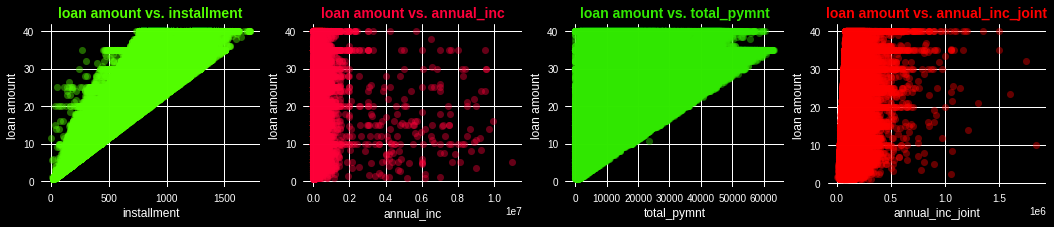

In [17]:
cols = ['installment','annual_inc','total_pymnt','annual_inc_joint']       
loan_df.drop(loan_df[loan_df.annual_inc>2e7].index, inplace=True)
loan_df.drop(loan_df[loan_df.annual_inc_joint>1.9e6].index, inplace=True)

plt.style.use('dark_background')
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(cols))]
for ii, cname in enumerate(cols) :
    seaborn.regplot(x=loan_df[cname], y=loan_df.loan_amnt/1e3, color=colors[ii], 
                    fit_reg=False, marker='o', scatter_kws={'s':50,'alpha':0.4}, ax=axes[ii])
    axes[ii].set_ylabel('loan amount', fontsize=12)
    axes[ii].set_xlabel(cname, fontsize=12)
    axes[ii].set_title('loan amount vs. ' + cname, color=colors[ii], fontweight='bold', size=14)

## 7. Two very important factors

Two very important factors are:
- Debt-to-income `dti` which is an indication of the level of debt of each individual consumer with respect to its total income
- Average length of employment `emp_len` which is an indication of how stable labor market is in that state

In [18]:
lst = loan_df.emp_length.unique()
def emp_len (s) :
    if s=='10+ years' : return 10
    elif s=='9 years' : return 9
    elif s=='8 years' : return 8
    elif s=='7 years' : return 7
    elif s=='6 years' : return 6
    elif s=='5 years' : return 5
    elif s=='4 years' : return 4
    elif s=='3 years' : return 3
    elif s=='2 years' : return 2
    elif s=='1 year' : return 1
    else: return 0

loan_df['emp_len_yrs'] = loan_df.emp_length.apply(emp_len)

In [19]:
by_status = pd.crosstab(loan_df.addr_state, loan_df.good_loan)
df = pd.DataFrame(columns=['st', 'total_ratio', 'good_loan_ratio', 'bad_loan_num',
                           'avg_dti', 'avg_emp_len'], 
                 index=loan_df.addr_state.unique())

df.st = loan_df.addr_state.unique()
df.bad_loan_num = (loan_df.good_loan.groupby(loan_df.addr_state).count() - 
                   loan_df.good_loan.groupby(loan_df.addr_state).sum())
df.total_ratio = loan_df.good_loan.groupby(loan_df.addr_state).count()/loan_df.shape[0]
df.good_loan_ratio = (loan_df.good_loan.groupby(loan_df.addr_state).sum()/
                      loan_df.good_loan.groupby(loan_df.addr_state).count())
df.avg_dti = loan_df.dti.groupby(loan_df.addr_state).mean()
df.avg_emp_len = loan_df.emp_len_yrs.groupby(loan_df.addr_state).mean()
df.head()

,st,total_ratio,good_loan_ratio,bad_loan_num,avg_dti,avg_emp_len
NY,NY,0.082448,0.854862,27052,16.836901,5.578787
LA,LA,0.011394,0.845452,3981,19.950426,5.608836
MI,MI,0.025997,0.865697,7893,19.239806,5.683495
WA,WA,0.020817,0.891160,5122,18.741018,5.429601
MD,MD,0.023890,0.859984,7562,18.300989,5.791031


In [20]:
for col in df.columns:
    df[col] = df[col].astype(str)
    
df['text'] = df['st'] + '<br>' +\
                'Nation-wide num. loan ratio: ' + df.total_ratio + '<br>'+\
                'Good loan ratio: ' + df.good_loan_ratio + '<br>'+\
                'Avearge debt-to-income: ' + df.avg_dti

data = [dict(type='choropleth', autocolorscale = False, colorscale=['red', 'pink', 'yellow', 'green'],
        locations = df['st'], z = df.good_loan_ratio, locationmode = 'USA-states',
        text = df['text'], marker = dict(line=dict(color='rgb(255,255,255)', width=2)),
        colorbar = dict(title = "ratio"))]

layout = dict(title = 'Lending Clubs Good Loans',
              geo = dict(scope = 'usa',
                         projection = dict(type='albers usa'),
                         showlakes = True,
                         lakecolor = 'rgb(255, 255, 255)'))

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-US-map')

## 8. One more important factor

- Credit scores `grade` indicate the overall level of risk. In general, the lower the grade of the credit score, the higher the risk for investors. In this section we look at the grade but a finer credit score `sub-grade` will also be used in our classification models

In [21]:
## Simple working example
dff = loan_df.loc[9530:9540, ['addr_state', 'grade', 'good_loan']]
print(dff)
print(pd.crosstab(dff.addr_state, dff.grade, values=dff.good_loan, aggfunc='sum'))

     addr_state grade  good_loan
9530         FL     D          1
9531         FL     C          1
9532         IN     B          1
9533         WA     B          1
9534         OK     B          1
9535         MO     B          1
9536         TX     A          0
9537         NY     D          1
9538         NJ     C          1
9539         FL     B          1
9540         FL     A          1
grade         A    B    C    D
addr_state                    
FL          1.0  1.0  1.0  1.0
IN          NaN  1.0  NaN  NaN
MO          NaN  1.0  NaN  NaN
NJ          NaN  NaN  1.0  NaN
NY          NaN  NaN  NaN  1.0
OK          NaN  1.0  NaN  NaN
TX          0.0  NaN  NaN  NaN
WA          NaN  1.0  NaN  NaN


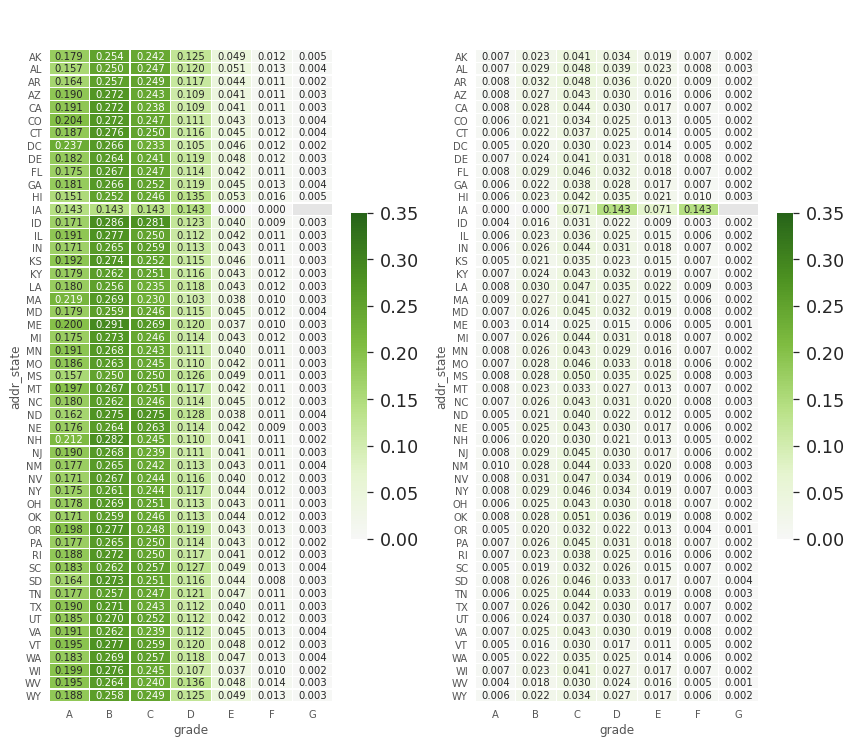

In [22]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(14, 12))
seaborn.set(font_scale=1.6)

## num of good loans in each grade and state divided by the total number of loans in each state
by_state_grade = pd.crosstab(loan_df.addr_state, loan_df.grade, values=loan_df.good_loan, aggfunc='sum')
for cname in by_state_grade.columns :
    by_state_grade[cname] = by_state_grade[cname]/loan_df.good_loan.groupby(loan_df.addr_state).count()
seaborn.heatmap(by_state_grade, vmin=0, vmax=0.35, cmap='PiYG', center=0, annot=True, 
                fmt='.3f', annot_kws={"size":10}, linewidths=0.2, linecolor='white', 
                cbar=True, ax=ax[0], cbar_kws={"shrink": 0.5});
ax[0].set_title('ratio of good loans by state and grade\n to all loans in each state')

## num of bad loans in each grade and state divided by the total number of loans in each state
by_state_grade = pd.crosstab(loan_df.addr_state, loan_df.grade, values=loan_df.bad_loan, aggfunc='sum')
for cname in by_state_grade.columns :
    by_state_grade[cname] = by_state_grade[cname]/loan_df.good_loan.groupby(loan_df.addr_state).count()
seaborn.heatmap(by_state_grade, vmin=0, vmax=0.35, cmap='PiYG', center=0, annot=True, 
                fmt='.3f', annot_kws={"size":10}, linewidths=0.2, linecolor='white', 
                cbar=True, ax=ax[1], cbar_kws={"shrink": 0.5});
ax[1].set_title('ratio of bad loans by state and grade\n to all loans in each state');

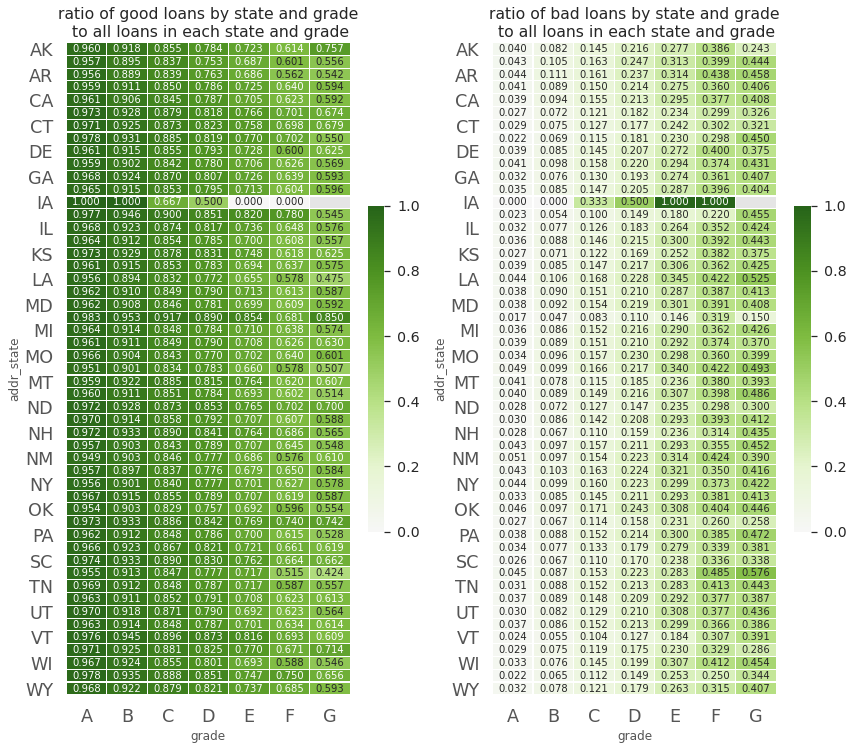

In [23]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(14, 12))
seaborn.set(font_scale=1.3)

## num of good loans in each grade and state divided by the total number of loans in each state and grade
by_state_grade = (pd.crosstab(loan_df.addr_state, loan_df.grade, values=loan_df.good_loan, aggfunc='sum')/
                  pd.crosstab(loan_df.addr_state, loan_df.grade, values=loan_df.good_loan, aggfunc='count'))
seaborn.heatmap(by_state_grade, cmap='PiYG', center=0, annot=True, fmt='.3f', annot_kws={"size":10}, 
                linewidths=0.1, linecolor='white', cbar=True, ax=ax[0], cbar_kws={"shrink": 0.5});
ax[0].set_title('ratio of good loans by state and grade\n to all loans in each state and grade')

## num of bad loans in each grade and state divided by the total number of loans in each state and grade
by_state_grade = (pd.crosstab(loan_df.addr_state, loan_df.grade, values=loan_df.bad_loan, aggfunc='sum')/
                  pd.crosstab(loan_df.addr_state, loan_df.grade, values=loan_df.bad_loan, aggfunc='count'))
seaborn.heatmap(by_state_grade, cmap='PiYG', center=0, annot=True, fmt='.3f', annot_kws={"size":10}, 
                linewidths=0.1, linecolor='white', cbar=True, ax=ax[1], cbar_kws={"shrink": 0.5});
ax[1].set_title('ratio of bad loans by state and grade\n to all loans in each state and grade');

## 9. Purpose of the loan is important

Text(0.5, 1.0, 'Ratio of good loans')

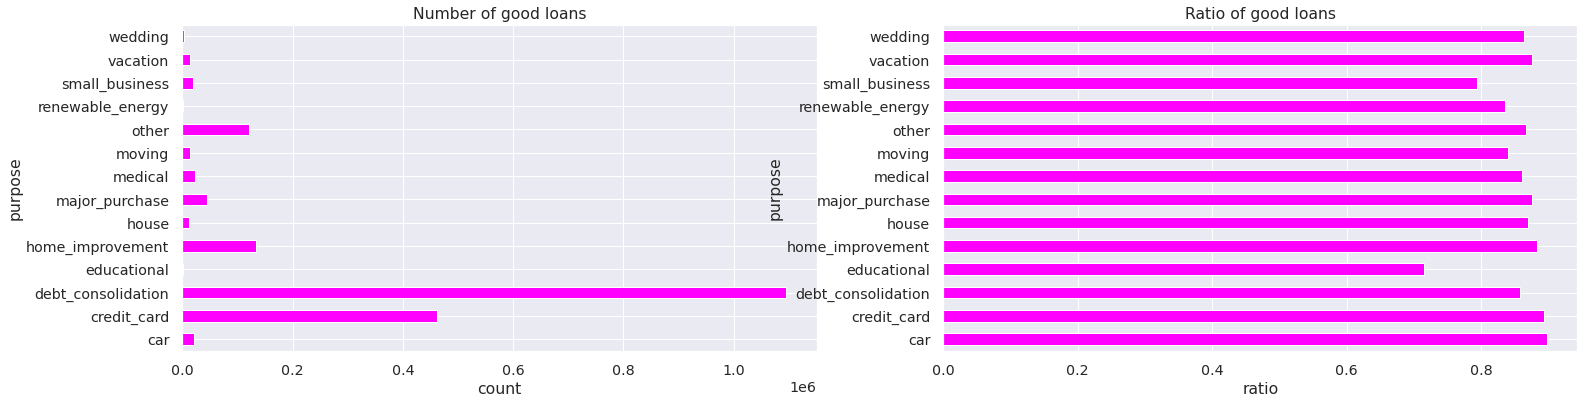

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(25, 6))

df = loan_df.good_loan.groupby(loan_df.purpose).sum()
df.plot(kind='barh', ax=axes[0], colormap='spring')
axes[0].set_xlabel('count')
axes[0].set_title('Number of good loans')

df = loan_df.good_loan.groupby(loan_df.purpose).sum()/loan_df.good_loan.groupby(loan_df.purpose).count()
df.plot(kind='barh', ax=axes[1], colormap='spring')
axes[1].set_xlabel('ratio')
axes[1].set_title('Ratio of good loans')

## 10. Drop irrelevant columns

In [25]:
loan_df.drop(['emp_length','loan_status','earliest_cr_line','inq_last_6mths','initial_list_status',
              'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
              'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
              'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med',
              'mths_since_last_major_derog','policy_code','annual_inc_joint','dti_joint',
              'verification_status_joint','tot_coll_amt','open_acc_6m','open_act_il','open_il_12m',
              'open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m',
              'all_util','total_cu_tl','inq_last_12m','mths_since_recent_bc_dlq','num_tl_120dpd_2m',
              'num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','revol_bal_joint',
              'sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc',
              'sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
              'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog','hardship_flag',
              'hardship_type','hardship_reason','hardship_status','deferral_term','hardship_amount',
              'hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_length',
              'hardship_dpd','hardship_loan_status','hardship_payoff_balance_amount','issue_d',
              'hardship_last_payment_amount','debt_settlement_flag','debt_settlement_flag_date',
              'settlement_status','settlement_date','settlement_amount','settlement_percentage',
              'orig_projected_additional_accrued_interest','settlement_term','bad_loan'], axis=1, inplace=True)

## 11. Turn categorical columns into numerics

In [26]:
cols = ['term','grade','sub_grade','emp_title','home_ownership','verification_status',
        'pymnt_plan','purpose','addr_state','application_type','disbursement_method']
for cname in cols :
    le = LabelEncoder()
    le.fit(list(loan_df[cname]))
    loan_df[cname] = le.transform(list(loan_df[cname].values))

In [27]:
good_loan = loan_df.good_loan
loan_df.drop(['good_loan'], axis=1, inplace=True)

In [41]:
good_loan = good_loan.to_numpy()

<class 'numpy.ndarray'>


## 12. Replace missing values

In [28]:
iter_impute = IterativeImputer(max_iter=10, tol=0.001, initial_strategy='mean')

data = loan_df.to_numpy()
iter_impute.fit(data[:, [10,15,16,17,18,19,20,22,23,25]])
data[:, [10,15,16,17,18,19,20,22,23,25]] = iter_impute.transform(data[:, [10,15,16,17,18,19,20,22,23,25]])

In [29]:
iter_impute = IterativeImputer(max_iter=10, tol=0.001, initial_strategy='mean')
iter_impute.fit(data[:, range(26,36)])
data[:, range(26,36)] = iter_impute.transform(data[:, range(26,36)])

In [30]:
iter_impute = IterativeImputer(max_iter=10, tol=0.001, initial_strategy='mean')
iter_impute.fit(data[:, range(36,46)])
data[:, range(36,46)] = iter_impute.transform(data[:, range(36,46)])

In [31]:
iter_impute = IterativeImputer(max_iter=10, tol=0.001, initial_strategy='mean')
iter_impute.fit(data[:, range(46,56)])
data[:, range(46,56)] = iter_impute.transform(data[:, range(46,56)])

In [32]:
iter_impute = IterativeImputer(max_iter=10, tol=0.001, initial_strategy='mean')
iter_impute.fit(data[:, range(56,64)])
data[:, range(56,64)] = iter_impute.transform(data[:, range(56,64)])

In [38]:
assert(np.any(np.isnan(data)) == False)
assert(np.any(np.isnan(good_loan)) == False)

## 13. Separate data into train and test

In [42]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1)
for train_idx, test_idx in sss.split(data, good_loan) :
    X_train, X_test = data[train_idx, :], data[test_idx, :]
    y_train, y_test = good_loan[train_idx], good_loan[test_idx]
    
print(X_train.shape, X_test.shape)
print(y_train.sum()/y_train.shape[0], ' vs. ', y_test.sum()/y_test.shape[0])

(2034594, 64) (226066, 64)
0.8680650783399538  vs.  0.8680650783399538


## 14. Resmple for a more balanced dataset

In [43]:
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = sm.fit_resample(X_test, y_test)

r1 = y_train.sum()/y_train.shape[0]
r2 = y_train_sm.sum()/y_train_sm.shape[0]
print('Before sampling--good loan ratio: %0.4f, bad loan ratio: %0.4f' %(r1, 1-r1))
print('After sampling--good loan ratio: %0.4f, bad loan ratio: %0.4f' %(r2, 1-r2))
print(X_train.shape, X_train_sm.shape)

Before sampling--good loan ratio: 0.8681, bad loan ratio: 0.1319
After sampling--good loan ratio: 0.5000, bad loan ratio: 0.5000
(2034594, 64) (3532320, 64)


## 15. z-score all columns

In [44]:
X_train_sm = StandardScaler().fit_transform(X_train_sm)
X_test_sm = StandardScaler().fit_transform(X_test_sm)

## 16. Building a model in keras

In [45]:
def loan_model (input_shape) :
    x_input = Input(input_shape)

    x = Dense(64, activation='tanh', kernel_initializer='glorot_uniform')(x_input)
    x = BatchNormalization(epsilon=0.01, momentum=0.99)(x)
    
    x = Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization(epsilon=0.01, momentum=0.99)(x)
    
    x = Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization(epsilon=0.01, momentum=0.99)(x)
    
    x = Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization(epsilon=0.01, momentum=0.99)(x)

    x_output = Dense(1, activation='sigmoid', use_bias=True, kernel_regularizer=regularizers.l2(0.01),
              bias_regularizer=regularizers.l2(0.02))(x)

    model = Model(inputs=x_input, outputs=x_output, name='loan_model')
    
    return model

In [46]:
loanModel = loan_model(np.shape(X_train_sm[1,:]))
print(loanModel.summary())

Model: "loan_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               5

In [47]:
optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99)
loanModel.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [48]:
loanModel.fit(x=X_train_sm, y=y_train_sm, batch_size=2048, epochs=50, verbose=1, 
              shuffle=True, validation_data=(X_test_sm, y_test_sm))

Epoch 1/50
1725/1725 [==============================] - 34s 20ms/step - loss: 0.2545 - accuracy: 0.7559 - val_loss: 0.1650 - val_accuracy: 0.7537
Epoch 2/50
1725/1725 [==============================] - 34s 19ms/step - loss: 0.1390 - accuracy: 0.8039 - val_loss: 0.1330 - val_accuracy: 0.8099
Epoch 3/50
1725/1725 [==============================] - 33s 19ms/step - loss: 0.1310 - accuracy: 0.8147 - val_loss: 0.1260 - val_accuracy: 0.8235
Epoch 4/50
1725/1725 [==============================] - 33s 19ms/step - loss: 0.1269 - accuracy: 0.8205 - val_loss: 0.1259 - val_accuracy: 0.8227
Epoch 5/50
1725/1725 [==============================] - 32s 18ms/step - loss: 0.1241 - accuracy: 0.8244 - val_loss: 0.1222 - val_accuracy: 0.8286
Epoch 6/50
1725/1725 [==============================] - 32s 19ms/step - loss: 0.1220 - accuracy: 0.8275 - val_loss: 0.1272 - val_accuracy: 0.8217
Epoch 7/50
1725/1725 [==============================] - 32s 19ms/step - loss: 0.1197 - accuracy: 0.8310 - val_loss: 0.1239 -

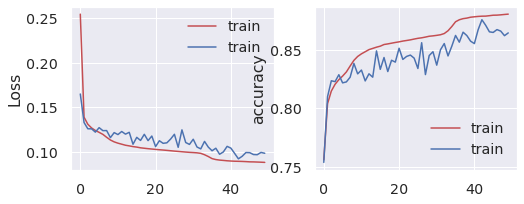

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))

axes[0].plot(loanModel.history.history['loss'], 'r', label='train')
axes[0].plot(loanModel.history.history['val_loss'], 'b', label='train')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(loanModel.history.history['accuracy'], 'r', label='train')
axes[1].plot(loanModel.history.history['val_accuracy'], 'b', label='train')
axes[1].set_ylabel('accuracy')
axes[1].legend()

## 17.1.Logistic Regression

In [50]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train_sm, y_train_sm)
y_pred = log_reg.predict(X_test_sm)
print('accuracy: %0.4f' %(metrics.accuracy_score(y_test_sm, y_pred)))

accuracy: 0.6810


## 17.2.Gradient Boosting Regressor

In [61]:
gbc = GBC(loss='deviance', learning_rate=0.02, n_estimators=10, min_samples_split=2, 
          min_samples_leaf=2, max_depth=3, verbose=1, tol=0.0001)
gbc.fit(X_train_sm, y_train_sm)
y_pred = gbc.predict(X_test_sm)
print('accuracy: %0.4f' %(metrics.accuracy_score(y_test_sm, y_pred)))

      Iter       Train Loss   Remaining Time 
         1           1.3710           13.04m
         2           1.3563           11.83m
         3           1.3422           10.28m
         4           1.3301            8.87m
         5           1.3184            7.45m
         6           1.3071            5.97m
         7           1.2947            4.50m
         8           1.2827            3.00m
         9           1.2725            1.50m
        10           1.2613            0.00s
accuracy: 0.5999


In [65]:
import gc
gc.collect()

52

## 17.3.LightGBM

In [63]:
lgbm = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=14, max_depth=8, learning_rate=0.02, 
                               n_estimators=100, min_child_weight=0.001, min_child_samples=20, 
                               n_jobs=-1, verbose=1)
lgbm.fit(X_train_sm, y_train_sm)
y_pred = lgbm.predict(X_test_sm)
print('accuracy: %0.4f' %(metrics.accuracy_score(y_test_sm, y_pred)))

accuracy: 0.6381


## **17.4. Stocastic Gradient Descent**

In [73]:
sgd = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, 
                               fit_intercept=True, max_iter=1000, tol=0.0001, shuffle=True, 
                               verbose=0, epsilon=0.1, n_jobs=-1, learning_rate='optimal')
sgd.fit(X_train_sm, y_train_sm)
y_pred = sgd.predict(X_test_sm)
print('accuracy: %0.4f' %(metrics.accuracy_score(y_test_sm, y_pred)))

accuracy: 0.6811


## 17.5. Stacking Classifiers

In [76]:
estimators = [('log', log_reg),   
              ('sgd', sgd),   
              ('gbc', gbc),   
              ('lgbm', lgbm)]

stack_class = SC(estimators=estimators, final_estimator=ETC(n_estimators=1), n_jobs=-1, verbose=2)
stack_class.fit(X_train_sm, y_train_sm)
y_pred = stack_class.predict(X_test_sm)
print('accuracy: %0.4f' %(metrics.accuracy_score(y_test_sm, y_pred)))

accuracy: 0.5427
